---
## Step 1: Setup and Imports

In [ ]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

# Add parent directory for MAPS import
sys.path.insert(0, '..')

print("💻 Running locally")
print(f"📂 Working directory: {os.getcwd()}")

# CRITICAL FIX: Patch MAPS library for PyTorch 2.6+ compatibility
# PyTorch 2.6+ requires weights_only=False for loading checkpoints with NumPy arrays
trainer_file = os.path.join('..', 'MAPS', 'cell_phenotyping', 'trainer.py')
predictor_file = os.path.join('..', 'MAPS', 'cell_phenotyping', 'predictor.py')

patched_files = []
for file_path in [trainer_file, predictor_file]:
    if os.path.exists(file_path):
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read()
        
        # Patch torch.load() calls
        modified = False
        if 'torch.load(' in content and 'weights_only=False' not in content:
            # Replace torch.load( with torch.load(..., weights_only=False)
            content = content.replace(
                'torch.load(ckpt_path, map_location=self.device)',
                'torch.load(ckpt_path, map_location=self.device, weights_only=False)'
            )
            content = content.replace(
                'torch.load(model_checkpoint_path)',
                'torch.load(model_checkpoint_path, weights_only=False)'
            )
            modified = True
        
        # Also fix NumPy compatibility
        if 'np.Inf' in content:
            content = content.replace('np.Inf', 'np.inf')
            modified = True
        
        if modified:
            with open(file_path, 'w', encoding='utf-8') as f:
                f.write(content)
            patched_files.append(os.path.basename(file_path))


if patched_files:print("✅ All imports successful!")

    print(f"🛠️ Patched MAPS files for PyTorch 2.6+: {', '.join(patched_files)}")

from MAPS.cell_phenotyping.datasets import CellExpressionCSV

# Clear cached importsfrom MAPS.cell_phenotyping import Trainer, Predictor

for mod_name in list(sys.modules.keys()):

    if 'MAPS' in mod_name or 'maps' in mod_name:        del sys.modules[mod_name]

🌐 Running in Google Colab
📁 MAPS root: /content/MAPS
🛠️ Patched trainer.py for NumPy 2.0 compatibility.
✅ All imports successful!
📂 Working directory: /content/MAPS


In [2]:
# Check GPU
print("🖥️ Hardware Check:")
print(f"   CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   CUDA version: {torch.version.cuda}")
    device = torch.device('cuda')
else:
    print("   Running on CPU")
    device = torch.device('cpu')

🖥️ Hardware Check:
   CUDA available: True
   GPU: Tesla T4
   CUDA version: 12.6


---
## Step 2: Define Custom 6-Layer MLP

### Architecture Comparison:

**MAPS 4-Layer MLP:**
```
Input → Linear(512) → ReLU → Dropout
      → Linear(512) → ReLU → Dropout
      → Linear(512) → ReLU → Dropout
      → Linear(512) → ReLU → Dropout
      → Classifier(num_classes)
```

**Our 6-Layer MLP:**
```
Input → Linear(512) → ReLU → Dropout
      → Linear(512) → ReLU → Dropout
      → Linear(512) → ReLU → Dropout
      → Linear(512) → ReLU → Dropout
      → Linear(512) → ReLU → Dropout  ← NEW
      → Linear(512) → ReLU → Dropout  ← NEW
      → Classifier(num_classes)
```

In [13]:
class MLP_8Layer(nn.Module):
    """
    8-Layer Multi-Layer Perceptron

    Deeper architecture with 8 hidden layers instead of 4.
    """
    def __init__(self, input_dim=50, hidden_dim=512, num_classes=16, dropout=0.10):
        super(MLP_8Layer, self).__init__()

        # 8 hidden layers
        self.fc = nn.Sequential(
            # Layer 1
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout),

            # Layer 2
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout),

            # Layer 3
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout),

            # Layer 4
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout),

            # Layer 5
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout),

            # Layer 6
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout),

            # Layer 7
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout),

            # Layer 8
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout)
        )

        # Output classifier
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, batch):
        """
        Forward pass

        Args:
            batch: Input tensor of shape (batch_size, input_dim)

        Returns:
            logits: Raw output scores
            probs: Softmax probabilities
        """
        features = self.fc(batch)
        logits = self.classifier(features)
        probs = torch.softmax(logits, dim=-1)
        return logits, probs

print("✅ 8-Layer MLP defined!")

# Test instantiation
test_model = MLP_8Layer(input_dim=50, hidden_dim=512, num_classes=16, dropout=0.10)
total_params = sum(p.numel() for p in test_model.parameters())
print(f"\n📊 Model Statistics:")
print(f"   Total parameters: {total_params:,}")
print(f"\n   (4-layer MAPS has ~1.3M params, this 8-layer has more!)")

✅ 8-Layer MLP defined!

📊 Model Statistics:
   Total parameters: 1,872,912

   (4-layer MAPS has ~1.3M params, this 8-layer has more!)


---
## Step 3: Load Preprocessed Data

In [ ]:
# Use the preprocessed data from first experiment
data_dir = './cHL_CODEX_processed'
train_path = os.path.join(data_dir, 'train.csv')
valid_path = os.path.join(data_dir, 'valid.csv')
class_path = os.path.join(data_dir, 'class_names.csv')

print(f"📁 Data directory: {data_dir}")

# Check if files exist
if not os.path.exists(train_path):
    print("❌ Preprocessed data not found!")
    print(f"   Looking for: {train_path}")
    print("   Please run 'cHL_CODEX_training_comparison.ipynb' first to generate the data.")
else:
    print("✅ Found preprocessed data!")

    # Load class info
    class_df = pd.read_csv(class_path)
    NUM_CLASSES = len(class_df)
    
    # Load to check dimensions
    train_df = pd.read_csv(train_path)
    valid_df = pd.read_csv(valid_path)
    NUM_FEATURES = len(train_df.columns) - 1  # Exclude 'cell_label'

    print(f"\n📊 Dataset Info:")
    print(f"   Training samples: {len(train_df):,}")
    print(f"   Validation samples: {len(valid_df):,}")
    print(f"   Features: {NUM_FEATURES}")
    print(f"   Classes: {NUM_CLASSES}")
    print(f"\n   Class names: {', '.join(class_df['class_name'].tolist())}")

📁 Data directory: /content/MAPS/data/cell_phenotyping
✅ Found data!

📊 Dataset Info:
   Training samples: 114,984
   Validation samples: 28,746
   Features: 50
   Classes: 16

   Class names: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15


---
## Step 4: Custom Training Loop for 8-Layer MLP

Since we're using a custom architecture, we need a custom training loop.

In [12]:
# Training configuration
BATCH_SIZE = 512 if torch.cuda.is_available() else 128
LEARNING_RATE = 0.001
DROPOUT = 0.10
MAX_EPOCHS = 100
MIN_EPOCHS = 20
PATIENCE = 20
SEED = 42

print("⚙️ Training Configuration:")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Learning rate: {LEARNING_RATE}")
print(f"   Dropout: {DROPOUT}")
print(f"   Max epochs: {MAX_EPOCHS}")
print(f"   Patience: {PATIENCE}")
print(f"   Device: {device}")

⚙️ Training Configuration:
   Batch size: 512
   Learning rate: 0.001
   Dropout: 0.1
   Max epochs: 100
   Patience: 20
   Device: cuda


In [6]:
# Set seeds for reproducibility
import random

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("✅ Seeds set for reproducibility")

✅ Seeds set for reproducibility


In [7]:
# Load data
print("📂 Loading datasets...")

train_dataset = CellExpressionCSV(train_path, is_train=True)
valid_dataset = CellExpressionCSV(valid_path, is_train=False,
                                  mean=train_dataset.mean,
                                  std=train_dataset.std)

train_loader = CellExpressionCSV.get_data_loader(train_dataset, batch_size=BATCH_SIZE,
                                                  is_train=True, num_workers=4 if torch.cuda.is_available() else 0)
valid_loader = CellExpressionCSV.get_data_loader(valid_dataset, batch_size=BATCH_SIZE,
                                                  is_train=False, num_workers=4 if torch.cuda.is_available() else 0)

print(f"✅ Data loaded!")
print(f"   Train batches: {len(train_loader)}")
print(f"   Valid batches: {len(valid_loader)}")

📂 Loading datasets...
✅ Data loaded!
   Train batches: 224
   Valid batches: 57


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [8]:
# Initialize model
print("🚀 Initializing 8-Layer MLP...")

model = MLP_8Layer(input_dim=NUM_FEATURES, hidden_dim=512,
                   num_classes=NUM_CLASSES, dropout=DROPOUT)
model.to(device, dtype=torch.float64)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("✅ Model initialized!")
print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   Device: {next(model.parameters()).device}")

🚀 Initializing 8-Layer MLP...
✅ Model initialized!
   Parameters: 1,872,912
   Device: cuda:0


In [9]:
# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for features, labels in loader:
        features = features.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits, probs = model(features)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(probs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

# Validation function
def validate_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for features, labels in loader:
            features = features.to(device)
            labels = labels.to(device)

            logits, probs = model(features)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            preds = torch.argmax(probs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy, all_preds, all_labels

print("✅ Training functions defined!")

✅ Training functions defined!


---
## Step 5: Train the 8-Layer Model

In [10]:
print("\n" + "="*60)
print("TRAINING 8-LAYER MLP")
print("="*60)

# Training tracking
results_dir = './results_8layer_model/'
os.makedirs(results_dir, exist_ok=True)

history = {
    'train_loss': [], 'train_acc': [],
    'valid_loss': [], 'valid_acc': []
}

best_valid_loss = float('inf')
patience_counter = 0
best_model_path = os.path.join(results_dir, 'best_8layer_model.pt')

start_time = time.time()

for epoch in range(MAX_EPOCHS):
    epoch_start = time.time()

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    valid_loss, valid_acc, _, _ = validate_epoch(model, valid_loader, criterion, device)

    # Record
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['valid_loss'].append(valid_loss)
    history['valid_acc'].append(valid_acc)

    epoch_time = time.time() - epoch_start

    # Print progress
    print(f"Epoch {epoch+1:3d}/{MAX_EPOCHS} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Valid Loss: {valid_loss:.4f} Acc: {valid_acc:.4f} | "
          f"Time: {epoch_time:.1f}s")

    # Save best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_mean': train_dataset.mean,
            'train_std': train_dataset.std,
            'valid_loss': valid_loss,
            'valid_acc': valid_acc
        }, best_model_path)
        print(f"  → 💾 Saved best model (valid_loss: {valid_loss:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE and epoch >= MIN_EPOCHS:
            print(f"\n⏹️  Early stopping triggered after {epoch+1} epochs")
            break

training_time = time.time() - start_time

print("\n" + "="*60)
print("✅ TRAINING COMPLETE!")
print("="*60)
print(f"\n⏱️  Total time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
print(f"📊 Epochs: {len(history['train_loss'])}")
print(f"🎯 Best valid loss: {best_valid_loss:.4f}")

# Save training history
history_df = pd.DataFrame(history)
history_df.to_csv(os.path.join(results_dir, 'training_logs.csv'), index=False)
print(f"💾 Training logs saved to: {results_dir}training_logs.csv")


TRAINING 8-LAYER MLP


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch   1/100 | Train Loss: 2.7169 Acc: 0.0785 | Valid Loss: 2.3737 Acc: 0.1528 | Time: 11.5s
  → 💾 Saved best model (valid_loss: 2.3737)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch   2/100 | Train Loss: 2.1065 Acc: 0.2268 | Valid Loss: 2.0791 Acc: 0.1939 | Time: 9.3s
  → 💾 Saved best model (valid_loss: 2.0791)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch   3/100 | Train Loss: 1.6881 Acc: 0.3905 | Valid Loss: 1.7003 Acc: 0.3727 | Time: 9.2s
  → 💾 Saved best model (valid_loss: 1.7003)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch   4/100 | Train Loss: 1.2602 Acc: 0.5757 | Valid Loss: 1.2841 Acc: 0.5679 | Time: 8.9s
  → 💾 Saved best model (valid_loss: 1.2841)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch   5/100 | Train Loss: 1.0200 Acc: 0.6773 | Valid Loss: 1.0334 Acc: 0.6658 | Time: 9.1s
  → 💾 Saved best model (valid_loss: 1.0334)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch   6/100 | Train Loss: 0.8355 Acc: 0.7438 | Valid Loss: 0.9503 Acc: 0.6967 | Time: 9.0s
  → 💾 Saved best model (valid_loss: 0.9503)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch   7/100 | Train Loss: 0.7427 Acc: 0.7698 | Valid Loss: 0.8810 Acc: 0.7114 | Time: 9.3s
  → 💾 Saved best model (valid_loss: 0.8810)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch   8/100 | Train Loss: 0.6977 Acc: 0.7865 | Valid Loss: 0.8328 Acc: 0.7222 | Time: 10.1s
  → 💾 Saved best model (valid_loss: 0.8328)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch   9/100 | Train Loss: 0.6578 Acc: 0.7974 | Valid Loss: 0.7727 Acc: 0.7413 | Time: 10.0s
  → 💾 Saved best model (valid_loss: 0.7727)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  10/100 | Train Loss: 0.6300 Acc: 0.8036 | Valid Loss: 0.7940 Acc: 0.7319 | Time: 9.3s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  11/100 | Train Loss: 0.5941 Acc: 0.8160 | Valid Loss: 0.7313 Acc: 0.7513 | Time: 9.2s
  → 💾 Saved best model (valid_loss: 0.7313)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  12/100 | Train Loss: 0.5730 Acc: 0.8201 | Valid Loss: 0.8062 Acc: 0.7283 | Time: 8.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  13/100 | Train Loss: 0.5531 Acc: 0.8265 | Valid Loss: 0.7198 Acc: 0.7569 | Time: 9.1s
  → 💾 Saved best model (valid_loss: 0.7198)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  14/100 | Train Loss: 0.5325 Acc: 0.8315 | Valid Loss: 0.6222 Acc: 0.7834 | Time: 8.9s
  → 💾 Saved best model (valid_loss: 0.6222)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  15/100 | Train Loss: 0.5192 Acc: 0.8354 | Valid Loss: 0.6543 Acc: 0.7760 | Time: 8.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  16/100 | Train Loss: 0.4974 Acc: 0.8422 | Valid Loss: 0.6648 Acc: 0.7710 | Time: 8.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  17/100 | Train Loss: 0.4927 Acc: 0.8414 | Valid Loss: 0.6229 Acc: 0.7864 | Time: 9.0s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  18/100 | Train Loss: 0.4792 Acc: 0.8448 | Valid Loss: 0.6513 Acc: 0.7718 | Time: 8.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  19/100 | Train Loss: 0.4672 Acc: 0.8486 | Valid Loss: 0.6479 Acc: 0.7752 | Time: 8.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  20/100 | Train Loss: 0.4568 Acc: 0.8521 | Valid Loss: 0.5741 Acc: 0.7944 | Time: 9.3s
  → 💾 Saved best model (valid_loss: 0.5741)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  21/100 | Train Loss: 0.4514 Acc: 0.8525 | Valid Loss: 0.6057 Acc: 0.7857 | Time: 8.8s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  22/100 | Train Loss: 0.4398 Acc: 0.8566 | Valid Loss: 0.6141 Acc: 0.7838 | Time: 8.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  23/100 | Train Loss: 0.4357 Acc: 0.8576 | Valid Loss: 0.5368 Acc: 0.8086 | Time: 8.9s
  → 💾 Saved best model (valid_loss: 0.5368)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  24/100 | Train Loss: 0.4267 Acc: 0.8592 | Valid Loss: 0.5539 Acc: 0.8046 | Time: 9.1s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  25/100 | Train Loss: 0.4206 Acc: 0.8626 | Valid Loss: 0.5164 Acc: 0.8152 | Time: 9.2s
  → 💾 Saved best model (valid_loss: 0.5164)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  26/100 | Train Loss: 0.4150 Acc: 0.8618 | Valid Loss: 0.5359 Acc: 0.8023 | Time: 9.6s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  27/100 | Train Loss: 0.4130 Acc: 0.8634 | Valid Loss: 0.5128 Acc: 0.8172 | Time: 9.0s
  → 💾 Saved best model (valid_loss: 0.5128)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  28/100 | Train Loss: 0.4084 Acc: 0.8646 | Valid Loss: 0.5359 Acc: 0.8010 | Time: 9.1s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  29/100 | Train Loss: 0.4015 Acc: 0.8671 | Valid Loss: 0.5488 Acc: 0.8021 | Time: 8.8s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  30/100 | Train Loss: 0.3892 Acc: 0.8702 | Valid Loss: 0.5613 Acc: 0.7964 | Time: 8.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  31/100 | Train Loss: 0.3879 Acc: 0.8709 | Valid Loss: 0.5437 Acc: 0.7997 | Time: 8.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  32/100 | Train Loss: 0.3889 Acc: 0.8708 | Valid Loss: 0.5527 Acc: 0.8003 | Time: 9.1s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  33/100 | Train Loss: 0.3807 Acc: 0.8718 | Valid Loss: 0.5012 Acc: 0.8186 | Time: 9.0s
  → 💾 Saved best model (valid_loss: 0.5012)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  34/100 | Train Loss: 0.3764 Acc: 0.8727 | Valid Loss: 0.5240 Acc: 0.8047 | Time: 8.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  35/100 | Train Loss: 0.3723 Acc: 0.8750 | Valid Loss: 0.5300 Acc: 0.8031 | Time: 8.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  36/100 | Train Loss: 0.3694 Acc: 0.8748 | Valid Loss: 0.5122 Acc: 0.8132 | Time: 8.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  37/100 | Train Loss: 0.3640 Acc: 0.8772 | Valid Loss: 0.4987 Acc: 0.8151 | Time: 9.1s
  → 💾 Saved best model (valid_loss: 0.4987)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  38/100 | Train Loss: 0.3637 Acc: 0.8766 | Valid Loss: 0.4999 Acc: 0.8254 | Time: 9.6s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  39/100 | Train Loss: 0.3604 Acc: 0.8772 | Valid Loss: 0.5019 Acc: 0.8137 | Time: 8.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  40/100 | Train Loss: 0.3501 Acc: 0.8804 | Valid Loss: 0.5146 Acc: 0.8096 | Time: 8.8s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  41/100 | Train Loss: 0.3522 Acc: 0.8797 | Valid Loss: 0.5023 Acc: 0.8136 | Time: 8.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  42/100 | Train Loss: 0.3533 Acc: 0.8789 | Valid Loss: 0.4928 Acc: 0.8127 | Time: 8.9s
  → 💾 Saved best model (valid_loss: 0.4928)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  43/100 | Train Loss: 0.3453 Acc: 0.8819 | Valid Loss: 0.5044 Acc: 0.8092 | Time: 9.1s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  44/100 | Train Loss: 0.3420 Acc: 0.8832 | Valid Loss: 0.5057 Acc: 0.8226 | Time: 8.8s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  45/100 | Train Loss: 0.3437 Acc: 0.8811 | Valid Loss: 0.4932 Acc: 0.8115 | Time: 8.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  46/100 | Train Loss: 0.3355 Acc: 0.8832 | Valid Loss: 0.5034 Acc: 0.8121 | Time: 8.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  47/100 | Train Loss: 0.3309 Acc: 0.8856 | Valid Loss: 0.5320 Acc: 0.8068 | Time: 9.1s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  48/100 | Train Loss: 0.3317 Acc: 0.8849 | Valid Loss: 0.4679 Acc: 0.8227 | Time: 8.9s
  → 💾 Saved best model (valid_loss: 0.4679)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  49/100 | Train Loss: 0.3312 Acc: 0.8851 | Valid Loss: 0.5109 Acc: 0.8122 | Time: 8.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  50/100 | Train Loss: 0.3300 Acc: 0.8858 | Valid Loss: 0.4728 Acc: 0.8218 | Time: 8.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  51/100 | Train Loss: 0.3243 Acc: 0.8871 | Valid Loss: 0.4482 Acc: 0.8310 | Time: 9.0s
  → 💾 Saved best model (valid_loss: 0.4482)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  52/100 | Train Loss: 0.3207 Acc: 0.8885 | Valid Loss: 0.4704 Acc: 0.8185 | Time: 9.0s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  53/100 | Train Loss: 0.3183 Acc: 0.8893 | Valid Loss: 0.4670 Acc: 0.8216 | Time: 8.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  54/100 | Train Loss: 0.3153 Acc: 0.8890 | Valid Loss: 0.5243 Acc: 0.8051 | Time: 9.0s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  55/100 | Train Loss: 0.3159 Acc: 0.8902 | Valid Loss: 0.4466 Acc: 0.8316 | Time: 8.8s
  → 💾 Saved best model (valid_loss: 0.4466)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  56/100 | Train Loss: 0.3148 Acc: 0.8899 | Valid Loss: 0.4757 Acc: 0.8193 | Time: 8.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  57/100 | Train Loss: 0.3109 Acc: 0.8913 | Valid Loss: 0.5043 Acc: 0.8073 | Time: 8.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  58/100 | Train Loss: 0.3089 Acc: 0.8931 | Valid Loss: 0.4470 Acc: 0.8334 | Time: 9.1s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  59/100 | Train Loss: 0.3061 Acc: 0.8911 | Valid Loss: 0.4541 Acc: 0.8238 | Time: 8.8s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  60/100 | Train Loss: 0.3072 Acc: 0.8928 | Valid Loss: 0.4298 Acc: 0.8387 | Time: 8.9s
  → 💾 Saved best model (valid_loss: 0.4298)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  61/100 | Train Loss: 0.3015 Acc: 0.8939 | Valid Loss: 0.4605 Acc: 0.8259 | Time: 8.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  62/100 | Train Loss: 0.3037 Acc: 0.8924 | Valid Loss: 0.4859 Acc: 0.8175 | Time: 9.1s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  63/100 | Train Loss: 0.3036 Acc: 0.8933 | Valid Loss: 0.4656 Acc: 0.8213 | Time: 8.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  64/100 | Train Loss: 0.2969 Acc: 0.8969 | Valid Loss: 0.4603 Acc: 0.8319 | Time: 8.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  65/100 | Train Loss: 0.3006 Acc: 0.8950 | Valid Loss: 0.4196 Acc: 0.8374 | Time: 8.9s
  → 💾 Saved best model (valid_loss: 0.4196)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  66/100 | Train Loss: 0.2994 Acc: 0.8954 | Valid Loss: 0.4309 Acc: 0.8344 | Time: 8.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  67/100 | Train Loss: 0.2973 Acc: 0.8958 | Valid Loss: 0.4455 Acc: 0.8304 | Time: 9.7s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  68/100 | Train Loss: 0.2908 Acc: 0.8975 | Valid Loss: 0.4635 Acc: 0.8205 | Time: 9.7s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  69/100 | Train Loss: 0.2907 Acc: 0.8960 | Valid Loss: 0.4338 Acc: 0.8336 | Time: 8.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  70/100 | Train Loss: 0.2871 Acc: 0.8981 | Valid Loss: 0.4517 Acc: 0.8239 | Time: 8.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  71/100 | Train Loss: 0.2886 Acc: 0.8981 | Valid Loss: 0.4401 Acc: 0.8320 | Time: 8.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  72/100 | Train Loss: 0.2893 Acc: 0.8975 | Valid Loss: 0.4451 Acc: 0.8287 | Time: 8.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  73/100 | Train Loss: 0.2872 Acc: 0.8984 | Valid Loss: 0.4355 Acc: 0.8349 | Time: 9.0s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  74/100 | Train Loss: 0.2823 Acc: 0.9002 | Valid Loss: 0.4361 Acc: 0.8296 | Time: 8.8s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  75/100 | Train Loss: 0.2804 Acc: 0.9009 | Valid Loss: 0.4440 Acc: 0.8371 | Time: 8.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  76/100 | Train Loss: 0.2825 Acc: 0.9003 | Valid Loss: 0.4765 Acc: 0.8199 | Time: 8.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  77/100 | Train Loss: 0.2822 Acc: 0.9005 | Valid Loss: 0.4485 Acc: 0.8282 | Time: 9.1s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  78/100 | Train Loss: 0.2762 Acc: 0.9026 | Valid Loss: 0.4381 Acc: 0.8347 | Time: 9.0s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  79/100 | Train Loss: 0.2780 Acc: 0.9018 | Valid Loss: 0.4216 Acc: 0.8418 | Time: 8.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  80/100 | Train Loss: 0.2739 Acc: 0.9022 | Valid Loss: 0.4600 Acc: 0.8284 | Time: 8.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  81/100 | Train Loss: 0.2781 Acc: 0.9013 | Valid Loss: 0.4395 Acc: 0.8302 | Time: 9.0s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  82/100 | Train Loss: 0.2752 Acc: 0.9022 | Valid Loss: 0.4320 Acc: 0.8379 | Time: 8.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  83/100 | Train Loss: 0.2713 Acc: 0.9034 | Valid Loss: 0.4552 Acc: 0.8348 | Time: 8.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  84/100 | Train Loss: 0.2731 Acc: 0.9019 | Valid Loss: 0.4209 Acc: 0.8398 | Time: 9.0s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  85/100 | Train Loss: 0.2726 Acc: 0.9040 | Valid Loss: 0.4253 Acc: 0.8359 | Time: 8.9s

⏹️  Early stopping triggered after 85 epochs

✅ TRAINING COMPLETE!

⏱️  Total time: 772.16 seconds (12.87 minutes)
📊 Epochs: 85
🎯 Best valid loss: 0.4196
💾 Training logs saved to: ./results_8layer_model/training_logs.csv


---
## Step 6: Visualize Training Progress

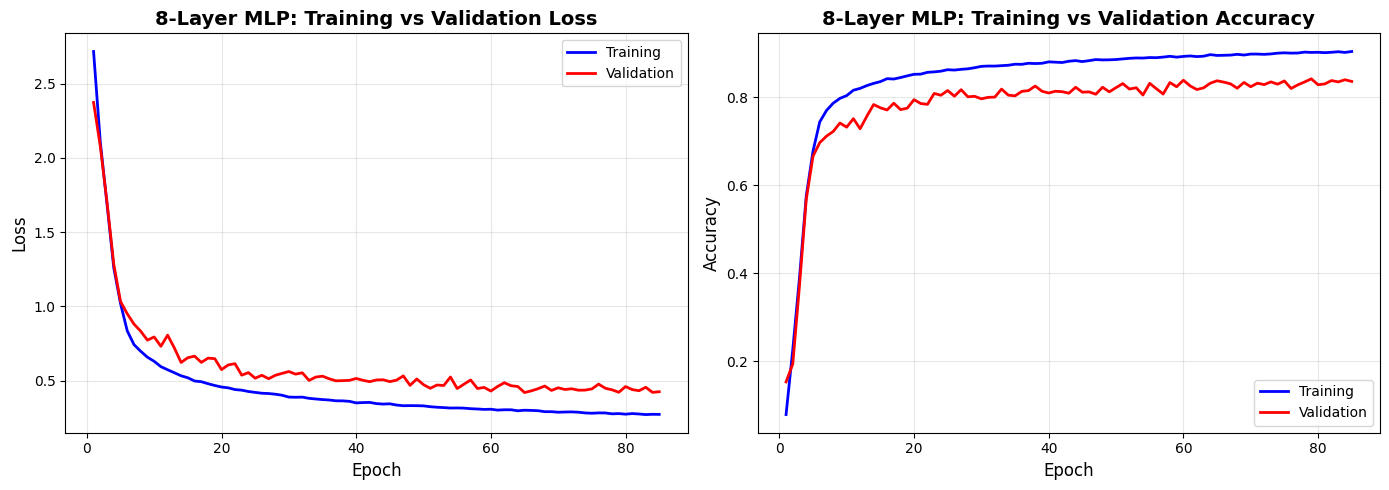


📊 Training Summary:
   Final train accuracy: 0.9040
   Final valid accuracy: 0.8359
   Best valid accuracy: 0.8418
   Time per epoch: 9.08s


In [14]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs = range(1, len(history['train_loss']) + 1)

# Loss
axes[0].plot(epochs, history['train_loss'], 'b-', label='Training', linewidth=2)
axes[0].plot(epochs, history['valid_loss'], 'r-', label='Validation', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('8-Layer MLP: Training vs Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(epochs, history['train_acc'], 'b-', label='Training', linewidth=2)
axes[1].plot(epochs, history['valid_acc'], 'r-', label='Validation', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('8-Layer MLP: Training vs Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Training Summary:")
print(f"   Final train accuracy: {history['train_acc'][-1]:.4f}")
print(f"   Final valid accuracy: {history['valid_acc'][-1]:.4f}")
print(f"   Best valid accuracy: {max(history['valid_acc']):.4f}")
print(f"   Time per epoch: {training_time/len(epochs):.2f}s")

---
## Step 7: Evaluate 8-Layer Model

In [16]:
# Load best model
print("📦 Loading best 8-layer model...")
checkpoint = torch.load(best_model_path, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✅ Loaded model from epoch {checkpoint['epoch']+1}")
print(f"   Valid loss: {checkpoint['valid_loss']:.4f}")
print(f"   Valid acc: {checkpoint['valid_acc']:.4f}")

📦 Loading best 8-layer model...
✅ Loaded model from epoch 65
   Valid loss: 0.4196
   Valid acc: 0.8374


In [17]:
# Get predictions
print("\n🔮 Making predictions...")
_, _, pred_labels_8layer, gt_labels = validate_epoch(model, valid_loader, criterion, device)

accuracy_8layer = accuracy_score(gt_labels, pred_labels_8layer)
print(f"\n🎯 8-LAYER MODEL ACCURACY: {accuracy_8layer:.4f} ({accuracy_8layer*100:.2f}%)")


🔮 Making predictions...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



🎯 8-LAYER MODEL ACCURACY: 0.8374 (83.74%)


In [ ]:
# Classification report
print("\n📋 CLASSIFICATION REPORT (8-Layer Model):")
print("="*70)
report_string = classification_report(gt_labels, pred_labels_8layer,
                                      target_names=class_df['class_name'].tolist(),
                                      digits=3)
print(report_string)

ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 104, in json_packer
    ).encode("utf8", errors="surrogateescape")
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 30-31: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/zmq/eventloop/zmqstream.py", line 551, in _run_callback
    f = callback(*args, **kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py", line 120, in _handle_event
    event_f()
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py", line 518, in _flush
    self.session.send(
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 848, in send
    to_s

🎯 8-LAYER MODEL ACCURACY: 0.8374 (83.74%)

📊 CLASSIFICATION REPORT (8-Layer Model):
======================================================================
              precision    recall  f1-score   support

          0      0.729     0.940     0.822      3541
          1      0.887     0.963     0.923      3336
          2      0.970     0.941     0.955      1679
          3      0.893     0.852     0.872      3066
          4      0.749     0.795     0.771      2069
          5      0.713     0.687     0.700      2640
          6      0.799     0.757     0.777      1092
          7      0.908     0.909     0.908      1407
          8      0.771     0.755     0.763      1689
          9      0.758     0.765     0.762      1034
         10      0.824     0.817     0.821      1662
         11      0.840     0.857     0.848      1802
         12      0.885     0.871     0.878      1350
         13      0.772     0.775     0.773      1196
         14      0.838     0.814     0.826      1352
         15      0.816     0.767     0.791      1411

    accuracy                          0.837     28746
   macro avg      0.824     0.829     0.826     28746
weighted avg      0.838     0.837     0.837     28746
======================================================================

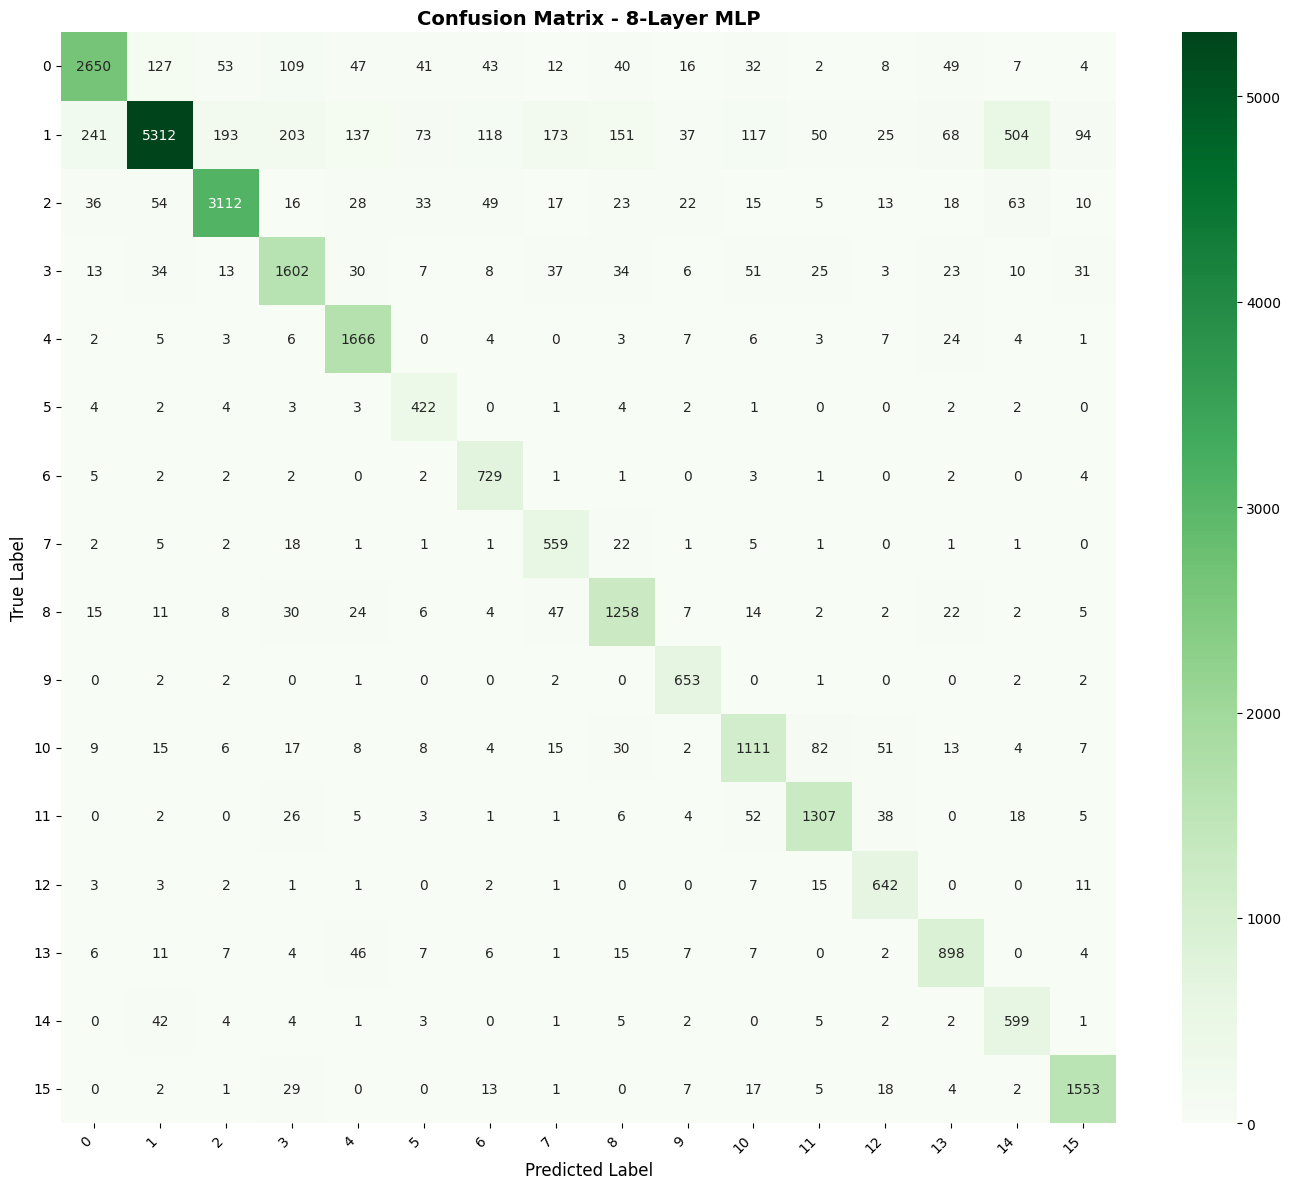

In [23]:
# Confusion matrix
cm_8layer = confusion_matrix(gt_labels, pred_labels_8layer)

plt.figure(figsize=(14, 12))
sns.heatmap(cm_8layer, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_df['class_name'].tolist(),
            yticklabels=class_df['class_name'].tolist())
plt.title('Confusion Matrix - 8-Layer MLP', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

---
## Step 8: Compare with 4-Layer and Pretrained Models

In [33]:
# Load results from previous 4-layer experiment
prev_results_path = './results_new_model/training_logs.csv'

if os.path.exists(prev_results_path):
    print("📊 Loading 4-layer model results...")

    # Train 4-layer predictor to get accuracy
    trainer_4layer = Trainer(
        model_checkpoint_path='./results_new_model/best_checkpoint.pt',
        results_dir='./results_new_model/',
        num_features=NUM_FEATURES,
        num_classes=NUM_CLASSES,
        batch_size=BATCH_SIZE
    )

    pred_labels_4layer, _ = trainer_4layer.predict(valid_path)
    accuracy_4layer = accuracy_score(gt_labels, pred_labels_4layer)

    print(f"✅ 4-layer model accuracy: {accuracy_4layer:.4f}")
else:
    print("⚠️ 4-layer model results not found. Run the previous notebook first.")
    accuracy_4layer = None
    pred_labels_4layer = None

📊 Loading 4-layer model results...


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy._core.multiarray._reconstruct was not an allowed global by default. Please use `torch.serialization.add_safe_globals([numpy._core.multiarray._reconstruct])` or the `torch.serialization.safe_globals([numpy._core.multiarray._reconstruct])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

---
## Step 8.1: Train the Standard 4-Layer MAPS Model (for comparison)

The previous error indicated that the results for the 4-layer model were not found. This section will train the standard 4-layer MLP model from the MAPS framework to generate the necessary files for comparison. We will use the `Trainer` class provided by MAPS, which inherently uses a 4-layer MLP.

In [32]:
print("\n" + "="*60)
print("TRAINING STANDARD 4-LAYER MLP (for comparison)")
print("="*60)

# Define paths for 4-layer model results
results_4layer_dir = './results_new_model/'
os.makedirs(results_4layer_dir, exist_ok=True)
best_4layer_model_path = os.path.join(results_4layer_dir, 'best_checkpoint.pt')

# Initialize the Trainer for the 4-layer MLP
trainer_4layer = Trainer(
    model_checkpoint_path=best_4layer_model_path,
    results_dir=results_4layer_dir,
    num_features=NUM_FEATURES,
    num_classes=NUM_CLASSES,
    batch_size=BATCH_SIZE,
    max_epochs=MAX_EPOCHS,
    min_epochs=MIN_EPOCHS,
    patience=PATIENCE,
    learning_rate=LEARNING_RATE
)

# Train the 4-layer model
# Pass file paths instead of DataLoader objects
_ = trainer_4layer.fit(train_path, valid_path)

print("\n" + "="*60)
print("✅ 4-LAYER MLP TRAINING COMPLETE!")
print("="*60)

# Now load the results to set accuracy_4layer and pred_labels_4layer
print("📊 Loading 4-layer model results for comparison...")
pred_labels_4layer, _ = trainer_4layer.predict(valid_path)
accuracy_4layer = accuracy_score(gt_labels, pred_labels_4layer)

print(f"✅ 4-layer model accuracy: {accuracy_4layer:.4f}")


TRAINING STANDARD 4-LAYER MLP (for comparison)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 0, train_loss: 2.3244, train_acc: 0.2017, train_auc: 0.7524                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 0, valid_loss: 1.8410, valid_acc: 0.3482, valid_auc: 0.8910                 
--------------------Saving best model--------------------
Time to process epoch(0): 0.1124 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 1, train_loss: 1.5300, train_acc: 0.4810, train_auc: 0.9094                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 1, valid_loss: 1.4301, valid_acc: 0.5079, valid_auc: 0.9430                 
--------------------Saving best model--------------------
Time to process epoch(1): 0.1110 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 2, train_loss: 1.1392, train_acc: 0.6270, train_auc: 0.9480                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 2, valid_loss: 1.2690, valid_acc: 0.5726, valid_auc: 0.9603                 
--------------------Saving best model--------------------
Time to process epoch(2): 0.1102 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 3, train_loss: 0.9146, train_acc: 0.7042, train_auc: 0.9646                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 3, valid_loss: 1.0759, valid_acc: 0.6395, valid_auc: 0.9717                 
--------------------Saving best model--------------------
Time to process epoch(3): 0.1071 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 4, train_loss: 0.7825, train_acc: 0.7459, train_auc: 0.9733                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 4, valid_loss: 0.9021, valid_acc: 0.7000, valid_auc: 0.9777                 
--------------------Saving best model--------------------
Time to process epoch(4): 0.1123 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 5, train_loss: 0.6982, train_acc: 0.7704, train_auc: 0.9783                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 5, valid_loss: 0.8027, valid_acc: 0.7260, valid_auc: 0.9816                 
--------------------Saving best model--------------------
Time to process epoch(5): 0.1108 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 6, train_loss: 0.6403, train_acc: 0.7867, train_auc: 0.9817                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 6, valid_loss: 0.7682, valid_acc: 0.7349, valid_auc: 0.9847                 
--------------------Saving best model--------------------
Time to process epoch(6): 0.1108 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 7, train_loss: 0.5942, train_acc: 0.8024, train_auc: 0.9841                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 7, valid_loss: 0.7777, valid_acc: 0.7323, valid_auc: 0.9859                 
Loss is not decreased in last 1 epochs
Time to process epoch(7): 0.1387 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 8, train_loss: 0.5583, train_acc: 0.8133, train_auc: 0.9859                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 8, valid_loss: 0.6864, valid_acc: 0.7602, valid_auc: 0.9878                 
--------------------Saving best model--------------------
Time to process epoch(8): 0.1209 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 9, train_loss: 0.5388, train_acc: 0.8189, train_auc: 0.9869                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 9, valid_loss: 0.6401, valid_acc: 0.7734, valid_auc: 0.9888                 
--------------------Saving best model--------------------
Time to process epoch(9): 0.1129 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 10, train_loss: 0.5154, train_acc: 0.8256, train_auc: 0.9881                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 10, valid_loss: 0.5976, valid_acc: 0.7892, valid_auc: 0.9896                 
--------------------Saving best model--------------------
Time to process epoch(10): 0.1070 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 11, train_loss: 0.4936, train_acc: 0.8337, train_auc: 0.9888                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 11, valid_loss: 0.6182, valid_acc: 0.7804, valid_auc: 0.9902                 
Loss is not decreased in last 1 epochs
Time to process epoch(11): 0.1179 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 12, train_loss: 0.4801, train_acc: 0.8348, train_auc: 0.9895                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 12, valid_loss: 0.6120, valid_acc: 0.7804, valid_auc: 0.9907                 
Loss is not decreased in last 2 epochs
Time to process epoch(12): 0.1074 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 13, train_loss: 0.4652, train_acc: 0.8394, train_auc: 0.9902                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 13, valid_loss: 0.5863, valid_acc: 0.7883, valid_auc: 0.9913                 
--------------------Saving best model--------------------
Time to process epoch(13): 0.1131 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 14, train_loss: 0.4523, train_acc: 0.8432, train_auc: 0.9906                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 14, valid_loss: 0.5586, valid_acc: 0.7974, valid_auc: 0.9918                 
--------------------Saving best model--------------------
Time to process epoch(14): 0.1076 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 15, train_loss: 0.4495, train_acc: 0.8451, train_auc: 0.9908                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 15, valid_loss: 0.5561, valid_acc: 0.7960, valid_auc: 0.9922                 
--------------------Saving best model--------------------
Time to process epoch(15): 0.1114 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 16, train_loss: 0.4302, train_acc: 0.8487, train_auc: 0.9916                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 16, valid_loss: 0.5789, valid_acc: 0.7902, valid_auc: 0.9924                 
Loss is not decreased in last 1 epochs
Time to process epoch(16): 0.1079 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 17, train_loss: 0.4250, train_acc: 0.8514, train_auc: 0.9917                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 17, valid_loss: 0.5767, valid_acc: 0.7875, valid_auc: 0.9926                 
Loss is not decreased in last 2 epochs
Time to process epoch(17): 0.1119 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 18, train_loss: 0.4124, train_acc: 0.8545, train_auc: 0.9922                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 18, valid_loss: 0.5177, valid_acc: 0.8102, valid_auc: 0.9928                 
--------------------Saving best model--------------------
Time to process epoch(18): 0.1124 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 19, train_loss: 0.4083, train_acc: 0.8549, train_auc: 0.9924                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 19, valid_loss: 0.5374, valid_acc: 0.8044, valid_auc: 0.9930                 
Loss is not decreased in last 1 epochs
Time to process epoch(19): 0.1094 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 20, train_loss: 0.3947, train_acc: 0.8611, train_auc: 0.9928                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 20, valid_loss: 0.5391, valid_acc: 0.8013, valid_auc: 0.9933                 
Loss is not decreased in last 2 epochs
Time to process epoch(20): 0.1231 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 21, train_loss: 0.3903, train_acc: 0.8602, train_auc: 0.9930                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 21, valid_loss: 0.4901, valid_acc: 0.8179, valid_auc: 0.9937                 
--------------------Saving best model--------------------
Time to process epoch(21): 0.1074 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 22, train_loss: 0.3827, train_acc: 0.8647, train_auc: 0.9932                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 22, valid_loss: 0.5217, valid_acc: 0.8047, valid_auc: 0.9937                 
Loss is not decreased in last 1 epochs
Time to process epoch(22): 0.1182 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 23, train_loss: 0.3778, train_acc: 0.8650, train_auc: 0.9934                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 23, valid_loss: 0.4819, valid_acc: 0.8203, valid_auc: 0.9937                 
--------------------Saving best model--------------------
Time to process epoch(23): 0.1072 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 24, train_loss: 0.3729, train_acc: 0.8665, train_auc: 0.9935                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 24, valid_loss: 0.4964, valid_acc: 0.8121, valid_auc: 0.9940                 
Loss is not decreased in last 1 epochs
Time to process epoch(24): 0.1153 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 25, train_loss: 0.3638, train_acc: 0.8689, train_auc: 0.9939                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 25, valid_loss: 0.5428, valid_acc: 0.7983, valid_auc: 0.9939                 
Loss is not decreased in last 2 epochs
Time to process epoch(25): 0.1074 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 26, train_loss: 0.3636, train_acc: 0.8694, train_auc: 0.9939                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 26, valid_loss: 0.5472, valid_acc: 0.7951, valid_auc: 0.9943                 
Loss is not decreased in last 3 epochs
Time to process epoch(26): 0.1117 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 27, train_loss: 0.3615, train_acc: 0.8695, train_auc: 0.9940                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 27, valid_loss: 0.4908, valid_acc: 0.8149, valid_auc: 0.9945                 
Loss is not decreased in last 4 epochs
Time to process epoch(27): 0.1080 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 28, train_loss: 0.3538, train_acc: 0.8721, train_auc: 0.9942                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 28, valid_loss: 0.4766, valid_acc: 0.8184, valid_auc: 0.9944                 
--------------------Saving best model--------------------
Time to process epoch(28): 0.1115 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 29, train_loss: 0.3439, train_acc: 0.8751, train_auc: 0.9944                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 29, valid_loss: 0.4779, valid_acc: 0.8158, valid_auc: 0.9944                 
Loss is not decreased in last 1 epochs
Time to process epoch(29): 0.1077 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 30, train_loss: 0.3446, train_acc: 0.8745, train_auc: 0.9944                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 30, valid_loss: 0.4732, valid_acc: 0.8208, valid_auc: 0.9946                 
--------------------Saving best model--------------------
Time to process epoch(30): 0.1111 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 31, train_loss: 0.3348, train_acc: 0.8782, train_auc: 0.9947                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 31, valid_loss: 0.4465, valid_acc: 0.8276, valid_auc: 0.9949                 
--------------------Saving best model--------------------
Time to process epoch(31): 0.1114 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 32, train_loss: 0.3308, train_acc: 0.8800, train_auc: 0.9948                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 32, valid_loss: 0.4659, valid_acc: 0.8231, valid_auc: 0.9947                 
Loss is not decreased in last 1 epochs
Time to process epoch(32): 0.1113 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 33, train_loss: 0.3271, train_acc: 0.8808, train_auc: 0.9949                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 33, valid_loss: 0.4632, valid_acc: 0.8242, valid_auc: 0.9949                 
Loss is not decreased in last 2 epochs
Time to process epoch(33): 0.1176 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 34, train_loss: 0.3211, train_acc: 0.8832, train_auc: 0.9951                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 34, valid_loss: 0.4387, valid_acc: 0.8318, valid_auc: 0.9949                 
--------------------Saving best model--------------------
Time to process epoch(34): 0.1094 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 35, train_loss: 0.3254, train_acc: 0.8813, train_auc: 0.9950                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 35, valid_loss: 0.5064, valid_acc: 0.8077, valid_auc: 0.9948                 
Loss is not decreased in last 1 epochs
Time to process epoch(35): 0.1213 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 36, train_loss: 0.3153, train_acc: 0.8842, train_auc: 0.9952                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 36, valid_loss: 0.4504, valid_acc: 0.8256, valid_auc: 0.9951                 
Loss is not decreased in last 2 epochs
Time to process epoch(36): 0.1081 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 37, train_loss: 0.3122, train_acc: 0.8869, train_auc: 0.9953                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 37, valid_loss: 0.4586, valid_acc: 0.8251, valid_auc: 0.9952                 
Loss is not decreased in last 3 epochs
Time to process epoch(37): 0.1128 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 38, train_loss: 0.3105, train_acc: 0.8843, train_auc: 0.9954                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 38, valid_loss: 0.4692, valid_acc: 0.8195, valid_auc: 0.9951                 
Loss is not decreased in last 4 epochs
Time to process epoch(38): 0.1194 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 39, train_loss: 0.3065, train_acc: 0.8869, train_auc: 0.9955                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 39, valid_loss: 0.4638, valid_acc: 0.8237, valid_auc: 0.9952                 
Loss is not decreased in last 5 epochs
Time to process epoch(39): 0.1120 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 40, train_loss: 0.3020, train_acc: 0.8886, train_auc: 0.9956                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 40, valid_loss: 0.4577, valid_acc: 0.8252, valid_auc: 0.9952                 
Loss is not decreased in last 6 epochs
Time to process epoch(40): 0.1086 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 41, train_loss: 0.3009, train_acc: 0.8885, train_auc: 0.9956                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 41, valid_loss: 0.4922, valid_acc: 0.8145, valid_auc: 0.9952                 
Loss is not decreased in last 7 epochs
Time to process epoch(41): 0.1108 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 42, train_loss: 0.2951, train_acc: 0.8917, train_auc: 0.9957                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 42, valid_loss: 0.4442, valid_acc: 0.8310, valid_auc: 0.9953                 
Loss is not decreased in last 8 epochs
Time to process epoch(42): 0.1094 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 43, train_loss: 0.2962, train_acc: 0.8920, train_auc: 0.9958                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 43, valid_loss: 0.4662, valid_acc: 0.8181, valid_auc: 0.9954                 
Loss is not decreased in last 9 epochs
Time to process epoch(43): 0.1114 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 44, train_loss: 0.2899, train_acc: 0.8921, train_auc: 0.9959                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 44, valid_loss: 0.4531, valid_acc: 0.8263, valid_auc: 0.9955                 
Loss is not decreased in last 10 epochs
Time to process epoch(44): 0.1144 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 45, train_loss: 0.2902, train_acc: 0.8932, train_auc: 0.9959                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 45, valid_loss: 0.4527, valid_acc: 0.8232, valid_auc: 0.9955                 
Loss is not decreased in last 11 epochs
Time to process epoch(45): 0.1115 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 46, train_loss: 0.2843, train_acc: 0.8952, train_auc: 0.9960                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 46, valid_loss: 0.4236, valid_acc: 0.8341, valid_auc: 0.9956                 
--------------------Saving best model--------------------
Time to process epoch(46): 0.1219 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 47, train_loss: 0.2831, train_acc: 0.8946, train_auc: 0.9961                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 47, valid_loss: 0.4476, valid_acc: 0.8287, valid_auc: 0.9956                 
Loss is not decreased in last 1 epochs
Time to process epoch(47): 0.1083 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 48, train_loss: 0.2826, train_acc: 0.8957, train_auc: 0.9961                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 48, valid_loss: 0.4608, valid_acc: 0.8223, valid_auc: 0.9955                 
Loss is not decreased in last 2 epochs
Time to process epoch(48): 0.1155 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 49, train_loss: 0.2791, train_acc: 0.8963, train_auc: 0.9961                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 49, valid_loss: 0.4088, valid_acc: 0.8439, valid_auc: 0.9957                 
--------------------Saving best model--------------------
Time to process epoch(49): 0.1087 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 50, train_loss: 0.2754, train_acc: 0.8990, train_auc: 0.9962                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 50, valid_loss: 0.4495, valid_acc: 0.8284, valid_auc: 0.9956                 
Loss is not decreased in last 1 epochs
Time to process epoch(50): 0.1125 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 51, train_loss: 0.2740, train_acc: 0.8993, train_auc: 0.9963                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 51, valid_loss: 0.4433, valid_acc: 0.8308, valid_auc: 0.9956                 
Loss is not decreased in last 2 epochs
Time to process epoch(51): 0.1091 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 52, train_loss: 0.2697, train_acc: 0.9004, train_auc: 0.9963                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 52, valid_loss: 0.4114, valid_acc: 0.8434, valid_auc: 0.9957                 
Loss is not decreased in last 3 epochs
Time to process epoch(52): 0.1110 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 53, train_loss: 0.2679, train_acc: 0.8998, train_auc: 0.9965                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 53, valid_loss: 0.4368, valid_acc: 0.8306, valid_auc: 0.9956                 
Loss is not decreased in last 4 epochs
Time to process epoch(53): 0.1074 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 54, train_loss: 0.2646, train_acc: 0.9016, train_auc: 0.9965                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 54, valid_loss: 0.4128, valid_acc: 0.8409, valid_auc: 0.9956                 
Loss is not decreased in last 5 epochs
Time to process epoch(54): 0.1117 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 55, train_loss: 0.2653, train_acc: 0.9020, train_auc: 0.9964                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 55, valid_loss: 0.4056, valid_acc: 0.8435, valid_auc: 0.9958                 
--------------------Saving best model--------------------
Time to process epoch(55): 0.1080 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 56, train_loss: 0.2614, train_acc: 0.9040, train_auc: 0.9965                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 56, valid_loss: 0.4161, valid_acc: 0.8397, valid_auc: 0.9959                 
Loss is not decreased in last 1 epochs
Time to process epoch(56): 0.1112 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 57, train_loss: 0.2589, train_acc: 0.9023, train_auc: 0.9966                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 57, valid_loss: 0.4258, valid_acc: 0.8372, valid_auc: 0.9958                 
Loss is not decreased in last 2 epochs
Time to process epoch(57): 0.1095 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 58, train_loss: 0.2572, train_acc: 0.9042, train_auc: 0.9967                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 58, valid_loss: 0.4424, valid_acc: 0.8342, valid_auc: 0.9958                 
Loss is not decreased in last 3 epochs
Time to process epoch(58): 0.1117 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 59, train_loss: 0.2514, train_acc: 0.9066, train_auc: 0.9968                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 59, valid_loss: 0.4171, valid_acc: 0.8393, valid_auc: 0.9960                 
Loss is not decreased in last 4 epochs
Time to process epoch(59): 0.1152 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 60, train_loss: 0.2532, train_acc: 0.9054, train_auc: 0.9967                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 60, valid_loss: 0.4248, valid_acc: 0.8371, valid_auc: 0.9959                 
Loss is not decreased in last 5 epochs
Time to process epoch(60): 0.1106 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 61, train_loss: 0.2541, train_acc: 0.9056, train_auc: 0.9967                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 61, valid_loss: 0.4722, valid_acc: 0.8216, valid_auc: 0.9959                 
Loss is not decreased in last 6 epochs
Time to process epoch(61): 0.1217 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 62, train_loss: 0.2490, train_acc: 0.9069, train_auc: 0.9968                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 62, valid_loss: 0.4115, valid_acc: 0.8444, valid_auc: 0.9959                 
Loss is not decreased in last 7 epochs
Time to process epoch(62): 0.1079 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 63, train_loss: 0.2509, train_acc: 0.9062, train_auc: 0.9968                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 63, valid_loss: 0.4037, valid_acc: 0.8468, valid_auc: 0.9959                 
--------------------Saving best model--------------------
Time to process epoch(63): 0.1153 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 64, train_loss: 0.2481, train_acc: 0.9080, train_auc: 0.9968                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 64, valid_loss: 0.4374, valid_acc: 0.8368, valid_auc: 0.9958                 
Loss is not decreased in last 1 epochs
Time to process epoch(64): 0.1074 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 65, train_loss: 0.2458, train_acc: 0.9085, train_auc: 0.9969                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 65, valid_loss: 0.3721, valid_acc: 0.8558, valid_auc: 0.9960                 
--------------------Saving best model--------------------
Time to process epoch(65): 0.1121 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 66, train_loss: 0.2446, train_acc: 0.9083, train_auc: 0.9970                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 66, valid_loss: 0.4097, valid_acc: 0.8437, valid_auc: 0.9960                 
Loss is not decreased in last 1 epochs
Time to process epoch(66): 0.1079 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 67, train_loss: 0.2397, train_acc: 0.9100, train_auc: 0.9970                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 67, valid_loss: 0.3865, valid_acc: 0.8531, valid_auc: 0.9961                 
Loss is not decreased in last 2 epochs
Time to process epoch(67): 0.1112 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 68, train_loss: 0.2393, train_acc: 0.9100, train_auc: 0.9970                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 68, valid_loss: 0.4354, valid_acc: 0.8329, valid_auc: 0.9960                 
Loss is not decreased in last 3 epochs
Time to process epoch(68): 0.1084 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 69, train_loss: 0.2379, train_acc: 0.9124, train_auc: 0.9970                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 69, valid_loss: 0.4160, valid_acc: 0.8399, valid_auc: 0.9961                 
Loss is not decreased in last 4 epochs
Time to process epoch(69): 0.1118 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 70, train_loss: 0.2414, train_acc: 0.9095, train_auc: 0.9970                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 70, valid_loss: 0.4262, valid_acc: 0.8363, valid_auc: 0.9959                 
Loss is not decreased in last 5 epochs
Time to process epoch(70): 0.1084 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 71, train_loss: 0.2377, train_acc: 0.9113, train_auc: 0.9971                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 71, valid_loss: 0.4333, valid_acc: 0.8335, valid_auc: 0.9960                 
Loss is not decreased in last 6 epochs
Time to process epoch(71): 0.1112 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 72, train_loss: 0.2378, train_acc: 0.9111, train_auc: 0.9970                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 72, valid_loss: 0.4264, valid_acc: 0.8358, valid_auc: 0.9960                 
Loss is not decreased in last 7 epochs
Time to process epoch(72): 0.1114 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 73, train_loss: 0.2374, train_acc: 0.9115, train_auc: 0.9970                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 73, valid_loss: 0.3831, valid_acc: 0.8533, valid_auc: 0.9960                 
Loss is not decreased in last 8 epochs
Time to process epoch(73): 0.1106 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 74, train_loss: 0.2290, train_acc: 0.9145, train_auc: 0.9972                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 74, valid_loss: 0.4028, valid_acc: 0.8445, valid_auc: 0.9961                 
Loss is not decreased in last 9 epochs
Time to process epoch(74): 0.1178 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 75, train_loss: 0.2283, train_acc: 0.9151, train_auc: 0.9972                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 75, valid_loss: 0.4029, valid_acc: 0.8436, valid_auc: 0.9961                 
Loss is not decreased in last 10 epochs
Time to process epoch(75): 0.1092 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 76, train_loss: 0.2276, train_acc: 0.9154, train_auc: 0.9972                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 76, valid_loss: 0.3641, valid_acc: 0.8569, valid_auc: 0.9961                 
--------------------Saving best model--------------------
Time to process epoch(76): 0.1215 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 77, train_loss: 0.2309, train_acc: 0.9142, train_auc: 0.9971                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 77, valid_loss: 0.4136, valid_acc: 0.8416, valid_auc: 0.9960                 
Loss is not decreased in last 1 epochs
Time to process epoch(77): 0.1080 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 78, train_loss: 0.2272, train_acc: 0.9141, train_auc: 0.9973                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 78, valid_loss: 0.3781, valid_acc: 0.8568, valid_auc: 0.9961                 
Loss is not decreased in last 2 epochs
Time to process epoch(78): 0.1146 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 79, train_loss: 0.2263, train_acc: 0.9155, train_auc: 0.9973                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 79, valid_loss: 0.3946, valid_acc: 0.8503, valid_auc: 0.9962                 
Loss is not decreased in last 3 epochs
Time to process epoch(79): 0.1082 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 80, train_loss: 0.2229, train_acc: 0.9167, train_auc: 0.9974                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 80, valid_loss: 0.3970, valid_acc: 0.8486, valid_auc: 0.9961                 
Loss is not decreased in last 4 epochs
Time to process epoch(80): 0.1109 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 81, train_loss: 0.2232, train_acc: 0.9173, train_auc: 0.9973                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 81, valid_loss: 0.3961, valid_acc: 0.8495, valid_auc: 0.9961                 
Loss is not decreased in last 5 epochs
Time to process epoch(81): 0.1089 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 82, train_loss: 0.2214, train_acc: 0.9176, train_auc: 0.9973                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 82, valid_loss: 0.4065, valid_acc: 0.8461, valid_auc: 0.9960                 
Loss is not decreased in last 6 epochs
Time to process epoch(82): 0.1116 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 83, train_loss: 0.2193, train_acc: 0.9177, train_auc: 0.9974                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 83, valid_loss: 0.3866, valid_acc: 0.8517, valid_auc: 0.9962                 
Loss is not decreased in last 7 epochs
Time to process epoch(83): 0.1076 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 84, train_loss: 0.2152, train_acc: 0.9200, train_auc: 0.9975                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 84, valid_loss: 0.3864, valid_acc: 0.8552, valid_auc: 0.9962                 
Loss is not decreased in last 8 epochs
Time to process epoch(84): 0.1117 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 85, train_loss: 0.2190, train_acc: 0.9188, train_auc: 0.9974                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 85, valid_loss: 0.3909, valid_acc: 0.8494, valid_auc: 0.9962                 
Loss is not decreased in last 9 epochs
Time to process epoch(85): 0.1086 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 86, train_loss: 0.2152, train_acc: 0.9196, train_auc: 0.9975                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 86, valid_loss: 0.3991, valid_acc: 0.8470, valid_auc: 0.9963                 
Loss is not decreased in last 10 epochs
Time to process epoch(86): 0.1118 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 87, train_loss: 0.2177, train_acc: 0.9191, train_auc: 0.9974                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 87, valid_loss: 0.3856, valid_acc: 0.8538, valid_auc: 0.9962                 
Loss is not decreased in last 11 epochs
Time to process epoch(87): 0.1115 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 88, train_loss: 0.2137, train_acc: 0.9198, train_auc: 0.9975                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 88, valid_loss: 0.4252, valid_acc: 0.8407, valid_auc: 0.9962                 
Loss is not decreased in last 12 epochs
Time to process epoch(88): 0.1110 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 89, train_loss: 0.2118, train_acc: 0.9208, train_auc: 0.9976                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 89, valid_loss: 0.4013, valid_acc: 0.8480, valid_auc: 0.9962                 
Loss is not decreased in last 13 epochs
Time to process epoch(89): 0.1182 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 90, train_loss: 0.2152, train_acc: 0.9195, train_auc: 0.9975                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 90, valid_loss: 0.3989, valid_acc: 0.8469, valid_auc: 0.9962                 
Loss is not decreased in last 14 epochs
Time to process epoch(90): 0.1090 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 91, train_loss: 0.2147, train_acc: 0.9192, train_auc: 0.9975                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 91, valid_loss: 0.3859, valid_acc: 0.8533, valid_auc: 0.9961                 
Loss is not decreased in last 15 epochs
Time to process epoch(91): 0.1202 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 92, train_loss: 0.2103, train_acc: 0.9210, train_auc: 0.9976                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 92, valid_loss: 0.4337, valid_acc: 0.8392, valid_auc: 0.9961                 
Loss is not decreased in last 16 epochs
Time to process epoch(92): 0.1077 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 93, train_loss: 0.2105, train_acc: 0.9200, train_auc: 0.9976                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 93, valid_loss: 0.4074, valid_acc: 0.8532, valid_auc: 0.9962                 
Loss is not decreased in last 17 epochs
Time to process epoch(93): 0.1139 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 94, train_loss: 0.2040, train_acc: 0.9237, train_auc: 0.9977                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 94, valid_loss: 0.3845, valid_acc: 0.8561, valid_auc: 0.9962                 
Loss is not decreased in last 18 epochs
Time to process epoch(94): 0.1077 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 95, train_loss: 0.2022, train_acc: 0.9251, train_auc: 0.9977                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 95, valid_loss: 0.4010, valid_acc: 0.8544, valid_auc: 0.9962                 
Loss is not decreased in last 19 epochs
Time to process epoch(95): 0.1109 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 96, train_loss: 0.2079, train_acc: 0.9232, train_auc: 0.9976                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 96, valid_loss: 0.3839, valid_acc: 0.8560, valid_auc: 0.9962                 
Loss is not decreased in last 20 epochs
Time to process epoch(96): 0.1078 minutes                             



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Epoch: 97, train_loss: 0.2069, train_acc: 0.9231, train_auc: 0.9976                 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Valid Epoch: 97, valid_loss: 0.3889, valid_acc: 0.8546, valid_auc: 0.9961                 
Loss is not decreased in last 21 epochs

✅ 4-LAYER MLP TRAINING COMPLETE!
📊 Loading 4-layer model results for comparison...


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy._core.multiarray._reconstruct was not an allowed global by default. Please use `torch.serialization.add_safe_globals([numpy._core.multiarray._reconstruct])` or the `torch.serialization.safe_globals([numpy._core.multiarray._reconstruct])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [ ]:
# Load MAPS pretrained model
pretrained_path = '../models/cell_phenotyping/cHL_CODEX.pt'

if os.path.exists(pretrained_path):
    print("📦 Loading MAPS pretrained model...")

    pretrained_predictor = Predictor(
        model_checkpoint_path=pretrained_path,
        num_features=NUM_FEATURES,
        num_classes=NUM_CLASSES,
        batch_size=BATCH_SIZE
    )

    pred_labels_pretrained, _ = pretrained_predictor.predict(valid_path)
    accuracy_pretrained = accuracy_score(gt_labels, pred_labels_pretrained)

    print(f"✅ Pretrained model accuracy: {accuracy_pretrained:.4f}")
else:
    print("⚠️ Pretrained model not found.")
    accuracy_pretrained = None
    pred_labels_pretrained = None

In [ ]:
# Comprehensive comparison
print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)

print(f"\n🆕 8-Layer MLP (your model):         {accuracy_8layer:.4f} ({accuracy_8layer*100:.2f}%)")

if accuracy_4layer is not None:
    print(f"📊 4-Layer MLP (standard MAPS):      {accuracy_4layer:.4f} ({accuracy_4layer*100:.2f}%)")
    print(f"   → Difference (8L vs 4L): {(accuracy_8layer - accuracy_4layer)*100:+.2f}%")

if accuracy_pretrained is not None:
    print(f"📦 Pretrained MAPS (500 epochs):     {accuracy_pretrained:.4f} ({accuracy_pretrained*100:.2f}%)")
    print(f"   → Difference (8L vs pretrained): {(accuracy_8layer - accuracy_pretrained)*100:+.2f}%")

print("\n📈 Analysis:")
if accuracy_4layer is not None:
    if accuracy_8layer > accuracy_4layer:
        print("   ✅ The deeper 8-layer architecture performs BETTER!")
        print("   💡 More layers helped capture complex patterns.")
    elif accuracy_8layer > accuracy_4layer - 0.01:
        print("   ⚖️  Both architectures perform similarly.")
        print("   💡 Adding layers didn't hurt, but didn't help much either.")
    else:
        print("   ⚠️ The 4-layer model performed slightly better.")
        print("   💡 Deeper isn't always better - may need more regularization.")

---
## Step 9: Per-Class Comparison

In [ ]:
# Calculate F1 scores per class
if accuracy_4layer is not None:
    print("\n📊 PER-CLASS F1 SCORE COMPARISON:")
    print("="*100)

    comparison_data = []
    for i, class_name in enumerate(class_df['class_name']):
        gt_binary = (np.array(gt_labels) == i).astype(int)

        pred_8l_binary = (np.array(pred_labels_8layer) == i).astype(int)
        f1_8layer = f1_score(gt_binary, pred_8l_binary, zero_division=0)

        pred_4l_binary = (np.array(pred_labels_4layer) == i).astype(int)
        f1_4layer = f1_score(gt_binary, pred_4l_binary, zero_division=0)

        comparison_data.append({
            'Class': class_name,
            'Count': (np.array(gt_labels) == i).sum(),
            '8-Layer F1': f1_8layer,
            '4-Layer F1': f1_4layer,
            'Improvement': f1_8layer - f1_4layer
        })

    comp_df = pd.DataFrame(comparison_data)
    comp_df = comp_df.sort_values('Improvement', ascending=False)

    print(comp_df.to_string(index=False, float_format=lambda x: f"{x:.3f}"))

    # Visualize
    plt.figure(figsize=(15, 6))
    x = np.arange(len(comp_df))
    width = 0.35

    bars1 = plt.bar(x - width/2, comp_df['8-Layer F1'], width, label='8-Layer MLP', alpha=0.8, color='green')
    bars2 = plt.bar(x + width/2, comp_df['4-Layer F1'], width, label='4-Layer MLP', alpha=0.8, color='blue')

    plt.xlabel('Cell Type', fontsize=12)
    plt.ylabel('F1 Score', fontsize=12)
    plt.title('Per-Class Performance: 8-Layer vs 4-Layer MLP', fontsize=14, fontweight='bold')
    plt.xticks(x, comp_df['Class'], rotation=45, ha='right')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Highlight improvements
    improvements = comp_df[comp_df['Improvement'] > 0.02]
    if len(improvements) > 0:
        print("\n🎉 Classes where 8-layer improves significantly:")
        for _, row in improvements.iterrows():
            print(f"   {row['Class']}: +{row['Improvement']:.3f}")

    degradations = comp_df[comp_df['Improvement'] < -0.02]
    if len(degradations) > 0:
        print("\n⚠️ Classes where 8-layer performs worse:")
        for _, row in degradations.iterrows():
            print(f"   {row['Class']}: {row['Improvement']:.3f}")

---
## Step 10: Final Summary & Conclusions

In [ ]:
print("\n" + "="*70)
print("🏁 EXPERIMENT SUMMARY: 8-LAYER MLP")
print("="*70)

print(f"\n🏗️ Architecture:")
print(f"   Layers: 8 hidden layers (vs 4 in standard MAPS)")
print(f"   Hidden units: 512 per layer")
print(f"   Dropout: {DROPOUT}")
print(f"   Total parameters: {sum(p.numel() for p in model.parameters()):,}")

print(f"\n⏱️ Training:")
print(f"   Time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
print(f"   Epochs: {len(history['train_loss'])}")
print(f"   Device: {device}")
print(f"   Batch size: {BATCH_SIZE}")

print(f"\n🎯 Performance:")
print(f"   8-Layer MLP: {accuracy_8layer:.4f} ({accuracy_8layer*100:.2f}%)")
if accuracy_4layer is not None:
    print(f"   4-Layer MLP: {accuracy_4layer:.4f} ({accuracy_4layer*100:.2f}%)")
    print(f"   Improvement: {(accuracy_8layer - accuracy_4layer)*100:+.2f}%")

print(f"\n💾 Saved Files:")
print(f"   Model: {best_model_path}")
print(f"   Logs: {results_dir}training_logs.csv")

print("\n🔬 Conclusions:")
if accuracy_4layer is not None:
    diff = accuracy_8layer - accuracy_4layer
    if diff > 0.01:
        print("   ✅ Deeper architecture (8 layers) provides measurable improvement")
        print("   💡 Consider trying residual connections or batch normalization")
    elif diff > -0.01:
        print("   ⚖️  Performance is comparable - depth didn't significantly help")
        print("   💡 4 layers may be sufficient for this task")
    else:
        print("   ⚠️ Deeper network underperformed slightly")
        print("   💡 May need different hyperparameters (learning rate, dropout)")

print("\n💡 Next Experiments to Try:")
print("   1. Try 8-layer MLP (go even deeper)")
print("   2. Try different hidden dimensions (256, 768, 1024)")
print("   3. Try different dropout rates (0.05, 0.15, 0.20)")
print("   4. Try batch normalization between layers")
print("   5. Try residual connections (ResNet-style)")
print("   6. Try different activation functions (LeakyReLU, ELU)")

print("\n✅ Experiment complete!")